# Predicting Video Game Sales

## Notes for cleaning dataset
- 269 dates missing, often for Japanese Releases or Atari 2600 games
- 245 dates added, some games seem to have been cancelled for a platform although there are numbers for sales volume, so it's best to sort them out (by Year_Of_Release == None)
- Many games seem to have been released in Japan only => Should be ignored (JP_Sales == Global_Sales otherwise)
- Some games explicitly stated (jp sales/japan sales/etc.) => merged logically with global title, sometimes strong effect; influence of Japan Sales would be missing for some rows otherwise
- Slightly contradictory information for a few rows merged anyway using max(entry1, entry2)
- "tbd" => None
- Fun Fact: River Raid a top seller!

In [2]:
# TODO: use functions
# TODO: clean code
# TODO: visualizations
# TODO: check regressor characteristics

# Import libraries necessary for this project
import numpy as np
import pandas as pd
import scipy as sp
import time

import matplotlib.pyplot as plt

# Allows the use of display() for DataFrames
from IPython.display import display

# sklearn stuff
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.tools.plotting import scatter_matrix
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split, learning_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet, LassoLars, Ridge
from sklearn import svm

# make pretty
plt.style.use('ggplot')

# Pretty display for notebooks
%matplotlib inline

# Data Schema

## Dataset 1 (Video_Games_Sales_as_at_22_Dec_2016.csv)
This is my main dataset. It will be used to predict video game sales.

| title           | description                                                   | data type |
|-----------------|---------------------------------------------------------------|-----------|
| Name            | Name of the game                                              | String    |
| Platform        | Platform                                                      | String    |
| Year_of_Release | Year of release                                               | Numeric   |
| Genre           | Genre                                                         | String    |
| Publisher       | Publisher                                                     | String    |
| NA_Sales        | Game sales in North America (in millions of units)            | Numeric   |
| EU_Sales        | Game sales in the European Union (in millions of units)       | Numeric   |
| JP_Sales        | Game sales in Japan (in millions of units)                    | Numeric   |
| Other_Sales     | Game sales in the rest of the world (in millions of units)    | Numeric   |
| Global_Sales    | Total sales in the world (in millions of units)               | Numeric   |
| Critic_Score    | Aggregate score compiled by Metacritic staff                  | Numeric   |
| Critic_Count    | The number of critics used in coming up with the Critic_score | Numeric   |
| User_Score      | Score by Metacritic's subscribers                             | Numeric   |
| User_Count      | Number of users who gave the user_score                       | Numeric   |
| Developer       | Party responsible for creating the game                       | String    |
| Rating          | The [ESRB](https://www.esrb.org/) ratings                     | String    |

## Dataset 2 (ign.csv)
This is my secondary dataset. It might be used to support the primary dataset, but this would probably require major effort for merging both.

| title           | description                                                   | data type |
|-----------------|---------------------------------------------------------------|-----------|
| ID              | ID                                                            | Numeric   |
| score_phrase    | Game rating as a phrase                                       | String    |
| title           | Name of the game                                              | String    |
| url             | URL to source of data                                         | String    |
| platform        | Platform                                                      | String    |
| score           | Game rating as a float                                        | Numeric   |
| genre           | Genre                                                         | String    |
| editors_choice  | Special recommendation of the editor                          | String    |
| release_year    | Year of release                                               | Numeric   |
| release_month   | Month of release                                              | Numeric   |
| release_day     | Day of release                                                | Numeric   |


We can remove several colums in dataset2 that we don't need:
* **ID** which is just an ID that's not used in dataset 1
* **score_phrase**, because it redundant to _score_ and less precise
* **url**, because that's just the origin of the data
* **release_month**, too much detail
* **release_day**, too much detail
The next step will be to load the datasets.

In [3]:
def loadDatasets(cleaned = True):
    """Load all necessary datasets"""
    # Load dataset #1
    if (cleaned):
        try:
            dataset1 = pd.read_csv("data/Video_Games_Sales_as_at_22_Dec_2016_cleaned.csv")
            #display("Dataset #1 has {} samples with {} possible features.".format(*dataset1.shape))
        except:
            display("Dataset #1 could not be loaded. Is the dataset missing?")
    else:
        try:
            dataset1 = pd.read_csv("data/Video_Games_Sales_as_at_22_Dec_2016.csv")
            #display("Dataset #1 has {} samples with {} possible features.".format(*dataset1.shape))

            # tbd to NaN (needed for uncleaned dataset)
            clean_dataset1 = clean_dataset1.replace('tbd', float('NaN'))

            # correct data types (needed for uncleaned dataset)
            clean_dataset1['User_Score'] = clean_dataset1['User_Score'].apply(pd.to_numeric)            
        except:
            display("Dataset #1 could not be loaded. Is the dataset missing?")
        
    # Load dataset #2
    try:
        dataset2 = pd.read_csv("data/ign.csv")
        #display("Dataset #2 has {} samples with {} possible features.".format(*dataset2.shape))
    except:
        display("Dataset #2 could not be loaded. Is the dataset missing?")

    return dataset1, dataset2

In [4]:
def showDatasetInfos(dataset):
    if (~dataset.empty):
        # Display a description of the datasets
        display(dataset.describe())
        display(dataset.head())
        display(dataset.tail())

In [5]:
def sanitizeDatasets(dataset):
    if (~dataset.empty):
        clean_dataset = dataset.copy()

        # beautify strings and kick (needed for uncleaned dataset)
        for i in range(0, len(clean_dataset.axes[1])):
            if (clean_dataset.ix[:,i].dtype == object):
                clean_dataset.ix[:,i] = clean_dataset.ix[:,i].str.strip()

        # Remove rows with empty values, we want full information
        for column in clean_dataset.axes[1]:
            clean_dataset = clean_dataset[clean_dataset[column].notnull()]

        # dataset1 is now clean, make a copy for possibe use later        
        return clean_dataset
    else:
        return None

In [6]:
def showColumnInfos(inputset):
    dataset = inputset.copy()
    # display some infos
    if (~dataset.empty):
        print ('DATASET ROWS: {}'.format(*dataset.shape))
        for item in dataset.keys():
            print ('Unique values for column \'{}\': {}'.format(item, dataset[item].unique().size))

In [7]:
def createFeaturePlatformManufacturer(inputset):
    dataset = inputset.copy()
    # TODO: proper sanitization    
    if (~dataset.empty):
        # Platform manufacturer based on the platform
        man_microsoft = ['PC', 'X360', 'XB', 'XOne'] # Yes, PC could be argued about
        man_nintendo  = ['3DS', 'DS', 'GBA', 'GC', 'N64', 'Wii', 'WiiU']
        man_sega      = ['DC', 'GEN', 'GG','SAT', 'SCD']
        man_sony      = ['PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV']
        man_other     = ['2600', '3DO', 'PC', 'PCFX', 'TG16', 'WS']

        dataset['Platform_Manufacturer'] = dataset['Platform'].map(lambda x:
            'Microsoft' if x in man_microsoft else
            'Nintendo' if x in man_nintendo else
            'Sega' if x in man_sega else
            'Sony' if x in man_sony else
            'Other' if x in man_other else
            float('NaN'))
        return dataset
    else:
        print ('There is something wrong in createFeaturePlatformManufacturer')
        return None

In [8]:
def createFeaturePortables(inputset):
    dataset = inputset.copy()
    # TODO: proper sanitization
    if (~dataset.empty):
        # Portable based on the platform
        portables = ['3DS', 'DS', 'GBA', 'GG', 'PSP', 'PSV', 'WS']
        dataset['Portable'] = dataset['Platform'].map(lambda x: True if x in portables else False)
        return dataset
    else:
        print ('There is something wrong in createFeaturePortables')
        return None

In [9]:
def convertNominalFeatures(inputset, columns):
    dataset = inputset.copy()
    # TODO: proper sanitization    
    if ((~dataset.empty) & (len(columns) != 0)):
        # create Boolean columns for each nominal variable
        for column in columns:
            if column in dataset.keys():
                for value in dataset[column].unique():
                    dataset[column + '_' + value] = dataset[column].map(lambda x: True if x == value else False)
        return dataset
    else:
        print ('There is something wrong in convertNominalFeatures')
        return None

In [10]:
def separateTargetValues(inputset):
    dataset = inputset.copy()
    # separate features and target values (sales volume)
    sales = pd.DataFrame()
    sales['Global'] = dataset['Global_Sales'].copy()
    sales['NA'] = dataset['NA_Sales'].copy()
    sales['EU'] = dataset['EU_Sales'].copy()
    sales['JP'] = dataset['JP_Sales'].copy()
    sales['Other'] = dataset['Other_Sales'].copy()

    # remove target columns
    features = dataset.drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], axis=1)
    
    return features, sales

In [11]:
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

In [12]:
# Print the results of prediction for both training and testing
def get_r2(X_train, y_train, X_test, y_test):
    r2_train = performance_metric(y_train, reg.predict(X_train))
    r2_test  = performance_metric(y_test, reg.predict(X_test))

    print "For training set, model has a coefficient of determination, R^2, of {:.4f}.".format(r2_train)
    print "For test set, model has a coefficient of determination, R^2, of {:.4f}.".format(r2_test)
    
    return min(r2_train, r2_test)

In [13]:
def showCorrelations(inputset, threshold = None):
    #TODO: sanitization
    dataset = inputset.copy()
    if ((type(threshold) != float) & (type(threshold) != int)):
        display(dataset.corr())
    else:
        display(dataset.corr()[abs(dataset.corr()) > threshold])

In [14]:
def dropNominalFeatures(inputset):
    dataset = inputset.copy()
    for column in dataset.keys():
        if (dataset[column].dtype == object):
            dataset = dataset.drop(column, axis = 1)
    return dataset

In [15]:
def removeOutliersManually(inputset):
    dataset = inputset.copy()
    # There are only few rows before 2000, because MetaCritic was founded in July 16, 1999
    # Also, looking at the sum of global sales grouped by year seamingly reveals a large
    # gap from 2000 to 2001 -- but there probably wasn't such a boost in video game sales, but
    # MetaCritit had to get going. We also have a gap from 2015 to 2016 in the other direction
    # Might be true, might also result from the fact that Christmas is late in the year and
    # games are often sold then which are not yet in the dataset
    # I consider the those rows before 2001 to be outliers to be removed, also those after 2015
    dataset = dataset[(dataset.Year_of_Release > 2000) & (dataset.Year_of_Release < 2016)]

    # Several titles seem to have sold tremendously, but they came along with Hardware bundles,
    # e.g. "Super Mario Kart Wii" with the Wii or "Kinect Adventures!" with the XBox 360
    # Sad to kick these out, as especially the Mario Games are nice!
    dataset = dataset[dataset.Name != 'Wii Sports']
    dataset = dataset[dataset.Name != 'Mario Kart Wii']
    dataset = dataset[dataset.Name != 'Wii Sports Resort']
    dataset = dataset[dataset.Name != 'New Super Mario Bros.']
    dataset = dataset[dataset.Name != 'Wii Play']
    dataset = dataset[dataset.Name != 'New Super Mario Bros. Wii']
    dataset = dataset[dataset.Name != 'Mario Kart DS']
    dataset = dataset[dataset.Name != 'Wii Fit']
    dataset = dataset[dataset.Name != 'Kinect Adventures!']
    dataset = dataset[dataset.Name != 'Wii Fit Plus']
    dataset = dataset[dataset.Name != 'Grand Theft Auto V']
    
    return dataset

In [16]:
def displayLearningCurve(X, y, regressor, n_splits, test_size, random_state, params = None):
    # create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = n_splits, test_size = test_size, random_state = random_state)

    # generate the training set sizes increasing by 50
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)

    # Create the figure window
    fig = plt.figure(figsize=(10,7))

    # Calculate the training and testing scores
    sizes, train_scores, test_scores = learning_curve(regressor, X, y, cv = cv, train_sizes = train_sizes, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_std = np.std(train_scores, axis = 1)
    train_mean = np.mean(train_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)

    # Subplot the learning curve
    ax = fig.add_subplot(1,1,1)
    ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
    ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
    ax.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha = 0.15, color = 'r')
    ax.fill_between(sizes, test_mean - test_std, test_mean + test_std, alpha = 0.15, color = 'g')

    # Labels
    ax.set_title('%s'%(regressor))
    ax.set_xlabel('Number of Training Points')
    ax.set_ylabel('Score')
    ax.set_xlim([0, X.shape[0]*0.8])
    ax.set_ylim([-0.05, 1.05])

    # Visual aesthetics
    #ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()

In [17]:
def standardizeDataFrame(dataset):
    scaler = StandardScaler().fit(dataset)
    data = scaler.transform(dataset)
    return pd.DataFrame(data = data, index = dataset.index, columns = dataset.keys()), scaler

In [18]:
def scaleDataFrame(dataset):
    scaler = MinMaxScaler().fit(dataset)
    data = scaler.transform(dataset)
    return pd.DataFrame(data = data, index = dataset.index, columns = dataset.keys()), scaler

In [19]:
def unscaleDataFrame(dataset, scaler):
    data = scaler.inverse_transform(dataset)
    return pd.DataFrame(data = data, index = dataset.index, columns = dataset.keys())

In [20]:
def showKBest(input_features, target, k = 5):
    features = input_features.copy()
    features_new = SelectKBest(mutual_info_regression, k=5).fit_transform(features, target)
    display(features.head())
    display(pd.DataFrame(features_new).head())

In [21]:
def boxcoxSeries(series, lmbda = None, shift = 1):
    if (series.dtype == object):
        return series, None
    return sp.stats.boxcox(series + shift, lmbda)

In [22]:
def boxcoxDataFrame(inputframe, lmbdas = None, columns = None, shift = 1):
    boxcox_dataframe = pd.DataFrame(index = inputframe.index, columns = inputframe.keys())
    boxcox_lmbdas = {}
    for feature in inputframe.keys():
        # I might want to clean up this mess ...
        if (columns == None):
            lmbdas2 = None if (lmbdas == None) else lmbdas[feature]
            boxcoxed = boxcoxSeries(inputframe[feature], lmbdas2, shift)
            boxcox_dataframe[feature] = boxcoxed[0] if (type(boxcoxed) == tuple) else boxcoxed
            boxcox_lmbdas[feature] = boxcoxed[1] if (lmbdas == None) else None
        elif (feature in columns):
            lmbdas2 = None if (lmbdas == None) else lmbdas[feature]
            boxcoxed = boxcoxSeries(inputframe[feature], lmbdas2, shift)
            boxcox_dataframe[feature] = boxcoxed[0] if (type(boxcoxed) == tuple) else boxcoxed
            boxcox_lmbdas[feature] = boxcoxed[1] if (lmbdas == None) else None                
        else:
            boxcox_dataframe[feature] = inputframe[feature]
            boxcox_lmbdas[feature] = None
    return boxcox_dataframe, boxcox_lmbdas

In [23]:
def unboxcoxSeries(series, lmbda, shift = 1):
    if (series.dtype == object):
        return series
    if ((lmbda == None) | ((type(lmbda) != np.float64) & (type(lmbda) != float))):
        return series
    if (lmbda == 0):
        return pd.Series(np.exp(series))
    else:
        return pd.Series(np.exp(np.log(lmbda * series + 1) / lmbda) - shift)

In [24]:
def unboxcoxDataFrame(inputframe, lmbdas, columns = None, shift = 1):
    if ((lmbdas == None) | (type(lmbdas) != dict)):
        return inputframe
    boxcox_dataframe = pd.DataFrame(index = inputframe.index, columns = inputframe.keys())
    for feature in inputframe.keys():
        if (columns == None):
            boxcox_dataframe[feature] = unboxcoxSeries(inputframe[feature], lmbdas[feature], shift)
        elif (feature in columns):
            boxcox_dataframe[feature] = unboxcoxSeries(inputframe[feature], lmbdas[feature], shift)
        else:
            boxcox_dataframe[feature] = inputframe[feature]
    return boxcox_dataframe

In [25]:
def removeOutliers(inputset, columns = None, threshold = 1.5, multeity = 1):
    from collections import Counter    

    dataset = inputset.copy()
    outliers = []
    iter_columns = columns if columns != None else dataset.keys()
    for feature in iter_columns:
        if dataset[feature].dtype == float:
            # Calculate multiple of interquartile range of feature
            q1 = dataset[feature].quantile(0.25)
            q3 = dataset[feature].quantile(0.75)
            step = (q3 - q1) * threshold
            
            outlier_set = dataset[~((dataset[feature] >= q1 - step) & (dataset[feature] <= q3 + step))]
            outliers.extend(outlier_set.index.values)            
            
            # Display the outlier count
            #print "Rows considered outliers for the feature '{}': {}".format(feature, outlier_set.shape[0])
    
    # get outlier indexes to be removed depending on multeity
    counter = Counter(outliers)
    delete_rows = []
    for key in counter:
        if counter[key] >= multeity:
            delete_rows.append(key)

    #print 'Removed {} rows with outliers of multeity {} or above.'.format(len(delete_rows), multeity)
    #print delete_rows
    return dataset.drop(pd.Index(delete_rows))

In [26]:
def fit_model(X, y, regressor, params, n_splits, test_size, random_state):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = n_splits, test_size = test_size, random_state = random_state)

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    
    # Return the optimal model after fitting the data

    return grid.best_estimator_

In [27]:
def getScores(X_train, y_train, X_test, y_test, regressor, params, n_splits, test_size, random_state):
    reg = fit_model(X_train, y_train, regressor, params, n_splits, test_size, random_state)
    reg_score_train = performance_metric(y_train, reg.predict(X_train))
    reg_score_test = performance_metric(y_test, reg.predict(X_test))
    reg_gap = abs(reg_score_train - reg_score_test)
    return reg, reg_score_train, reg_score_test, reg_gap

In [28]:
def prepare_sets(standardize_set, scale_set_0_1, boxcox_set, outlier_threshold, outlier_multiety, test_size, n_splits, random_state):
    
    dataset1, dataset2 = loadDatasets()
    clean_dataset1 = sanitizeDatasets(dataset1)
    short_dataset1 = clean_dataset1.copy()
    short_dataset1['User_Score'] = short_dataset1['User_Score'] * 10
    short_dataset1 = createFeaturePlatformManufacturer(short_dataset1)
    short_dataset1 = createFeaturePortables(short_dataset1)
    short_dataset1 = removeOutliersManually(short_dataset1.copy())
    short_dataset1 = short_dataset1.drop(['Name', 'Publisher', 'Developer'], axis=1)
    short_dataset1 = convertNominalFeatures(short_dataset1, ['Platform', 'Genre', 'Rating', 'Platform_Manufacturer'])
    short_dataset1 = dropNominalFeatures(short_dataset1)
    test_set1 = short_dataset1.copy()
    if (standardize_set == True):
        short_dataset1, std_scaler = standardizeDataFrame(short_dataset1)
    if (scale_set_0_1 == True):
        short_dataset1, minmax_scaler = scaleDataFrame(short_dataset1)
    if (boxcox_set == True):
        short_dataset1, boxcox_lmbdas = boxcoxDataFrame(short_dataset1.copy(), columns=['Critic_Score', 'User_Score'])
    short_dataset1 = removeOutliers(short_dataset1.copy(), columns = ['Year_of_Release', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count','Global_Sales'], threshold = outlier_threshold, multeity = outlier_multiety)
    features, sales = separateTargetValues(short_dataset1)
    test_features, test_sales = separateTargetValues(test_set1)
    X_train, X_test, y_train, y_test = train_test_split(features, sales['Global'], test_size = test_size, random_state = random_state)
    return X_train, y_train, X_test, y_test

In [29]:
def computeSkewness(dataframe):
    from scipy.stats import skew
    for feature in dataframe.keys():
        print 'skewness for {} is: {}'.format(feature, skew(dataframe[feature]))

## Begin of analysis

In [30]:
dataset1, dataset2 = loadDatasets()

In [31]:
showDatasetInfos(dataset1)

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,16579.000000,16603.000000,16603.000000,16603.000000,16603.000000,16603.000000,8137.000000,8137.000000,7590.000000,7590.000000
mean,2006.473129,0.264786,0.145962,0.078023,0.047637,0.536665,68.967679,26.360821,7.125046,162.229908
std,5.932192,0.815941,0.504897,0.309813,0.187323,1.552928,13.938165,18.980495,1.500006,561.282326
min,1977.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,6.400000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,7.500000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,8.200000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,9.700000,10665.000000


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
16598,XI Coliseum,PSP,2006.0,Puzzle,Sony Computer Entertainment,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16599,Yattaman Wii: BikkuriDokkiri Machine de Mou Ra...,Wii,2008.0,Racing,Takara Tomy,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16600,Zero no Tsukaima: Maigo no Period to Ikusen no...,PS2,2008.0,Adventure,Marvelous Interactive,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16601,Zettai Kaikyuu Gakuen: Eden with Roses and Pha...,PSV,2016.0,Adventure,Prototype,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16602,ZombiU,XOne,2016.0,Action,Ubisoft,0.0,0.01,0.00,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Sanitization
clean_dataset1 = sanitizeDatasets(dataset1)

# Infos
showColumnInfos(clean_dataset1)

DATASET ROWS: 6942
Unique values for column 'Name': 4416
Unique values for column 'Platform': 17
Unique values for column 'Year_of_Release': 25
Unique values for column 'Genre': 12
Unique values for column 'Publisher': 261
Unique values for column 'NA_Sales': 352
Unique values for column 'EU_Sales': 273
Unique values for column 'JP_Sales': 157
Unique values for column 'Other_Sales': 144
Unique values for column 'Global_Sales': 538
Unique values for column 'Critic_Score': 82
Unique values for column 'Critic_Count': 106
Unique values for column 'User_Score': 89
Unique values for column 'User_Count': 879
Unique values for column 'Developer': 1295
Unique values for column 'Rating': 7


In [33]:
# Feature Generation and further harmonizing data

# make a short dataset that will contain all rows considered for further analysis

short_dataset1 = clean_dataset1.copy()

#rescale column for human readability
short_dataset1['User_Score'] = short_dataset1['User_Score'] * 10

# make feature for "platform manufacturer"
short_dataset1 = createFeaturePlatformManufacturer(short_dataset1)

# make feature for "portable"
short_dataset1 = createFeaturePortables(short_dataset1)

showDatasetInfos(short_dataset1)

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000
mean,2007.424517,0.393222,0.234968,0.063940,0.082244,0.774568,70.270815,28.877845,71.842553,173.819793
std,4.204915,0.961456,0.682568,0.285433,0.267921,1.949378,13.884912,19.197734,14.409487,584.709510
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,5.000000,4.000000
25%,2004.000000,0.060000,0.020000,0.000000,0.010000,0.110000,62.000000,14.000000,65.000000,11.000000
50%,2007.000000,0.150000,0.060000,0.000000,0.020000,0.290000,72.000000,24.000000,75.000000,27.000000
75%,2010.000000,0.390000,0.210000,0.020000,0.070000,0.750000,80.000000,39.000000,82.000000,88.000000
max,2016.000000,41.360000,28.960000,6.500000,10.570000,82.530000,98.000000,113.000000,96.000000,10665.000000


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Platform_Manufacturer,Portable
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,80.0,322.0,Nintendo,E,Nintendo,False
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,83.0,709.0,Nintendo,E,Nintendo,False
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,80.0,192.0,Nintendo,E,Nintendo,False
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,85.0,431.0,Nintendo,E,Nintendo,True
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,66.0,129.0,Nintendo,E,Nintendo,False


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Platform_Manufacturer,Portable
16114,Greg Hastings' Tournament Paintball Max'd,PS2,2006.0,Shooter,Activision,0.01,0.00,0.0,0.0,0.01,70.0,8.0,92.0,32.0,Activision Value,E10+,Sony,False
16115,Deus Ex,PC,2000.0,Role-Playing,Eidos Interactive,0.00,0.01,0.0,0.0,0.01,90.0,28.0,93.0,1069.0,Ion Storm,M,Microsoft,False
16116,Monster Rancher Advance 2,GBA,2002.0,Simulation,Tecmo Koei,0.01,0.00,0.0,0.0,0.01,79.0,5.0,94.0,9.0,"Tecmo, Graphic Research",E,Nintendo,True
16117,Wade Hixton's Counter Punch,GBA,2004.0,Sports,"Destination Software, Inc",0.01,0.00,0.0,0.0,0.01,78.0,13.0,95.0,4.0,Inferno Games,T,Nintendo,True
16118,Karnaaj Rally,GBA,2003.0,Racing,Jaleco,0.01,0.00,0.0,0.0,0.01,81.0,9.0,95.0,4.0,"Infinite Dreams, Paragon 5",E,Nintendo,True


In [34]:
# Outliers (manually)
#groups = short_dataset1['Global_Sales'].groupby(short_dataset1['Year_of_Release'])
#display(groups.sum())

# Look for outliers regarding Sales
display(short_dataset1.sort_values(['Global_Sales'], ascending = False).head(15))

short_dataset1 = removeOutliersManually(short_dataset1.copy())

# display some infos
print ('REMAINING ROWS IN DATASET #1: {}'.format(*short_dataset1.shape))
print ('Dataset #1 has games from {} unique years'.format(short_dataset1['Year_of_Release'].unique().size))

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Platform_Manufacturer,Portable
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,80.0,322.0,Nintendo,E,Nintendo,False
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,83.0,709.0,Nintendo,E,Nintendo,False
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,80.0,192.0,Nintendo,E,Nintendo,False
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,85.0,431.0,Nintendo,E,Nintendo,True
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,66.0,129.0,Nintendo,E,Nintendo,False
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.44,6.94,4.70,2.24,28.32,87.0,80.0,84.0,594.0,Nintendo,E,Nintendo,False
11,Mario Kart DS,DS,2005.0,Racing,Nintendo,9.71,7.47,4.13,1.90,23.21,91.0,64.0,86.0,464.0,Nintendo,E,Nintendo,True
13,Wii Fit,Wii,2007.0,Sports,Nintendo,8.92,8.03,3.60,2.15,22.70,80.0,63.0,77.0,146.0,Nintendo,E,Nintendo,False
14,Kinect Adventures!,X360,2010.0,Misc,Microsoft Game Studios,15.00,4.89,0.24,1.69,21.81,61.0,45.0,63.0,106.0,Good Science Studio,E,Microsoft,False
15,Wii Fit Plus,Wii,2009.0,Sports,Nintendo,9.01,8.49,2.53,1.77,21.79,80.0,33.0,74.0,52.0,Nintendo,E,Nintendo,False


REMAINING ROWS IN DATASET #1: 6532
Dataset #1 has games from 15 unique years


In [35]:
# Show correlations between all variables
showCorrelations(short_dataset1, 0.7)

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Portable
Year_of_Release,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NA_Sales,NaN,1.000000,0.702105,NaN,NaN,0.919290,NaN,NaN,NaN,NaN,NaN
EU_Sales,NaN,0.702105,1.000000,NaN,NaN,0.879879,NaN,NaN,NaN,NaN,NaN
JP_Sales,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Other_Sales,NaN,NaN,NaN,NaN,1.000000,0.733975,NaN,NaN,NaN,NaN,NaN
Global_Sales,NaN,0.919290,0.879879,NaN,0.733975,1.000000,NaN,NaN,NaN,NaN,NaN
Critic_Score,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Critic_Count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
User_Score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
User_Count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In order to understand the dataset better, we should have a look at possible values.

In [36]:
# => too many unique values per feature for the dataset size, so features should be removed
short_dataset1 = short_dataset1.drop(['Name', 'Publisher', 'Developer'], axis=1)

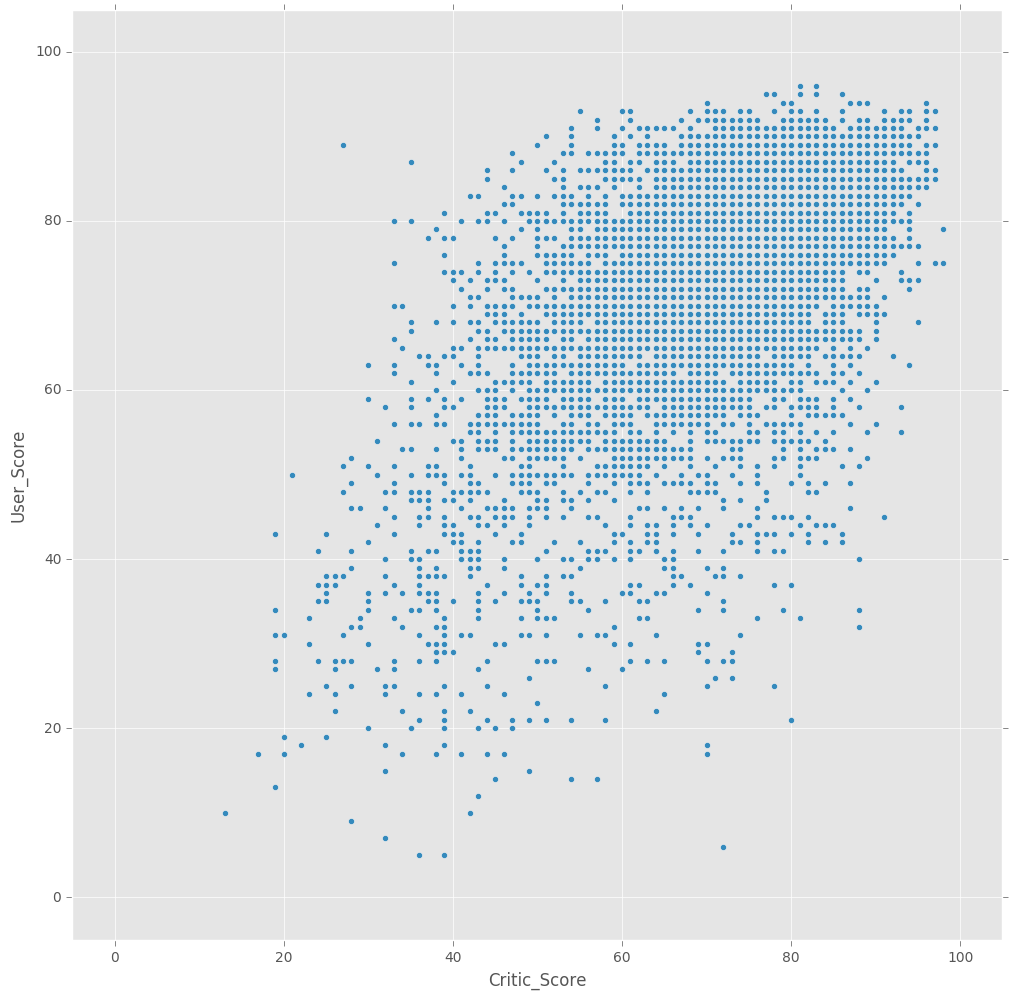

In [37]:
# Critic_Score and User_Score
short_dataset1.plot.scatter(x='Critic Score', y='User Score', xlim=(-5, 105), ylim=(-5,105), figsize=(12,12))

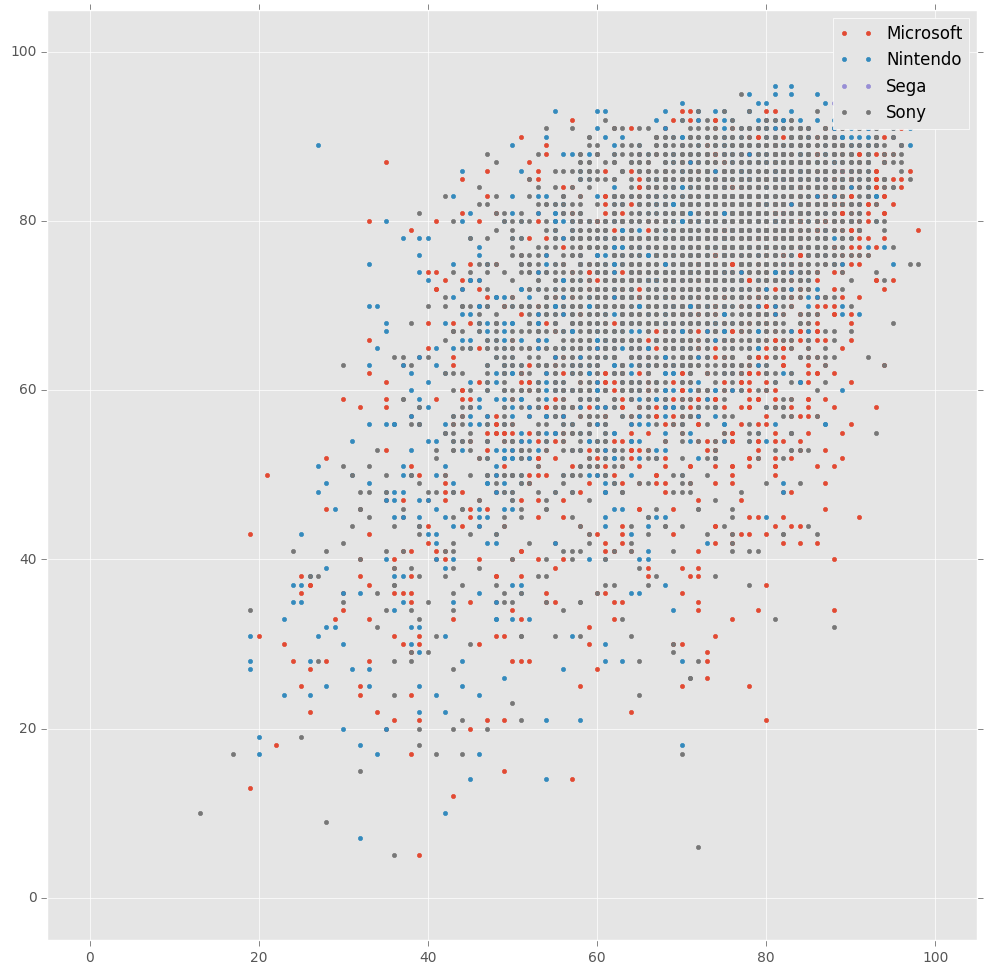

In [67]:
if ('Platform_Manufacturer' in short_dataset1.keys()):
    groups = short_dataset1.groupby('Platform_Manufacturer')

    # Plot
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, xlim=(-5,105), ylim=(-5,105))
    for name, group in groups:
        ax.plot(group.Critic_Score, group.User_Score, marker='.', linestyle='', label=name)
    ax.legend()
    plt.show()
    #fig.savefig('yourfilename.png')

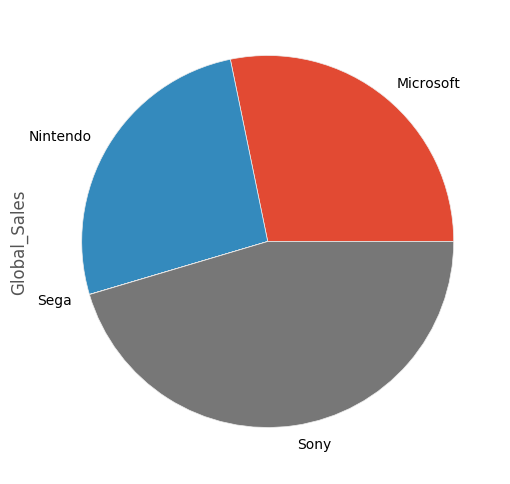

In [53]:
groups = short_dataset1.groupby('Platform_Manufacturer')
groups.Global_Sales.sum().plot.pie(figsize=(6, 6))

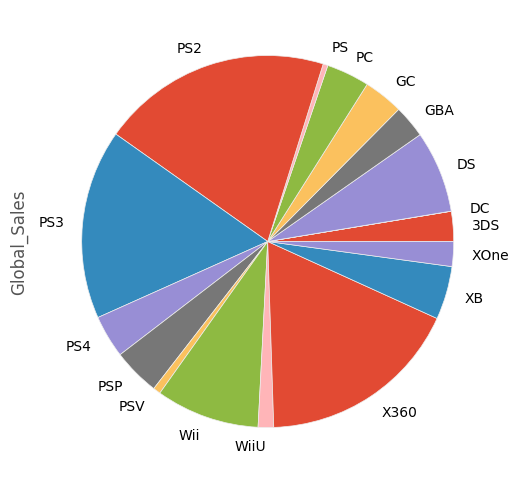

In [54]:
groups = short_dataset1.groupby('Platform')
groups.Global_Sales.sum().plot.pie(figsize=(6, 6))

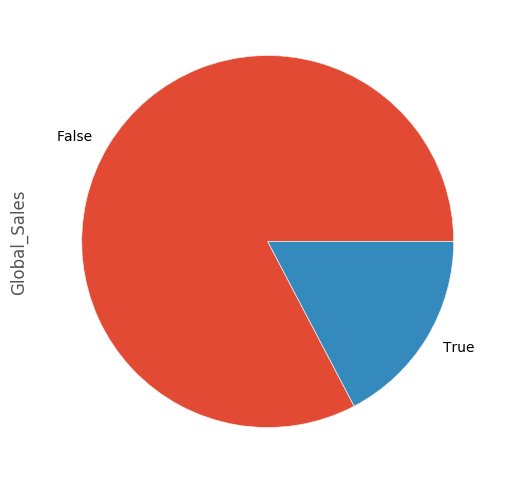

In [55]:
groups = short_dataset1.groupby('Portable')
groups.Global_Sales.sum().plot.pie(figsize=(6, 6))

In [448]:
# convert nominal features to boolean features
short_dataset1 = convertNominalFeatures(short_dataset1, ['Platform', 'Genre', 'Rating', 'Platform_Manufacturer'])
short_dataset1 = dropNominalFeatures(short_dataset1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6eea29ce90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6ee9dce8d0>]], dtype=object)

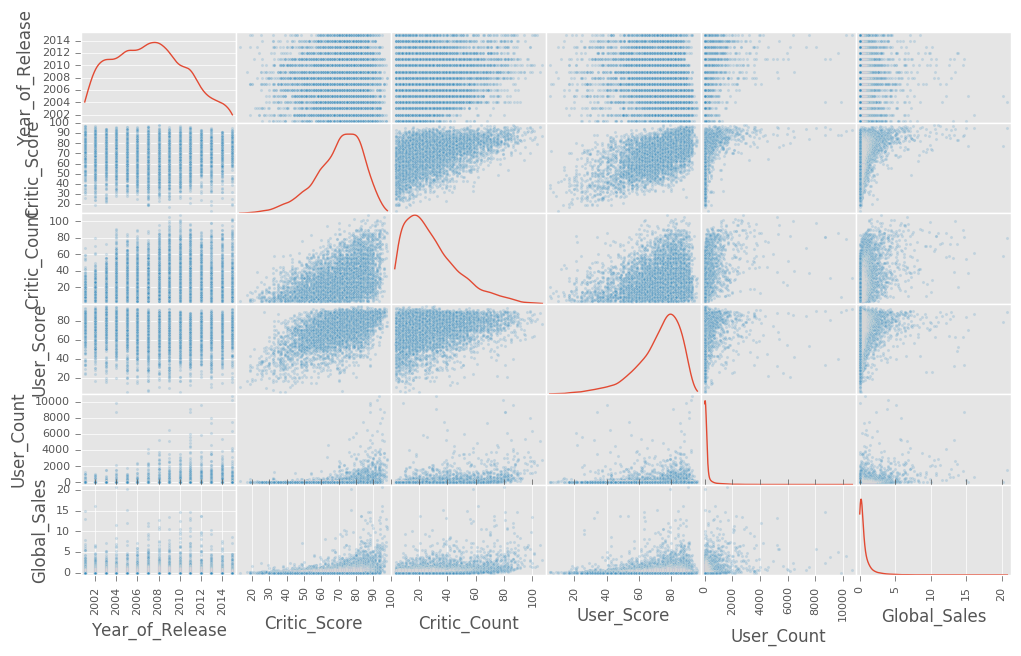

In [449]:
# show distributions
matrix_dataset1 = short_dataset1[['Year_of_Release', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Global_Sales']]
scatter_matrix(matrix_dataset1, alpha=0.2, figsize=(12, 7), diagonal='kde')

In [450]:
computeSkewness(matrix_dataset1)

# transforming years wouldn't make sense (and it randomly is fairly normally distributed)
# transforming sales probably doesn't make sense either, "long tail"
# transforming count might be speculative
# transforming scores might be a way to go

skewness for Year_of_Release is: 0.189587541338
skewness for Critic_Score is: -0.75265124413
skewness for Critic_Count is: 0.998701168757
skewness for User_Score is: -1.21958167202
skewness for User_Count is: 9.06350679478
skewness for Global_Sales is: 5.64859785092


In [451]:
# test_set
test_set1 = short_dataset1.copy()

# standardize features
#short_dataset1, std_scaler = standardizeDataFrame(short_dataset1)

# scale features to range [0, 1]
# short_dataset1, minmax_scaler = scaleDataFrame(short_dataset1)

# run Box-Cox transformation => screws up, better r2, but only for transformed data
short_dataset1, boxcox_lmbdas = boxcoxDataFrame(short_dataset1.copy(), columns=['Critic_Score', 'User_Score'])

In [452]:
# For each feature find the data points with extreme high or low values

display(short_dataset1.describe())
 
# We could construct outliers mathematically, but we probably only have representative outliers that should
# remain in the set (Chambers, 1986)
#short_dataset1 = removeOutliers(short_dataset1.copy(), columns = ['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count'], threshold = 1.5, multeity = 2)
#display(short_dataset1.describe())

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,6532.000000,6532.000000,6532.000000,6532.000000,6532.000000,6532.000000,6532.000000,6532.000000,6532.000000,6532.000000
mean,2007.375689,0.369166,0.212889,0.054698,0.077737,0.714698,6118.985333,29.131813,68248.023361,166.719688
std,3.776525,0.676554,0.470482,0.233946,0.231290,1.323190,2347.891689,19.040382,29730.799373,574.346912
min,2001.000000,0.000000,0.000000,0.000000,0.000000,0.010000,157.821853,3.000000,54.897355,4.000000
25%,2004.000000,0.060000,0.020000,0.000000,0.010000,0.117500,4471.176968,15.000000,47434.345928,11.000000
50%,2007.000000,0.150000,0.060000,0.000000,0.020000,0.290000,6202.486884,25.000000,70582.816502,26.000000
75%,2010.000000,0.390000,0.200000,0.010000,0.070000,0.742500,7814.417752,40.000000,90468.167596,84.000000
max,2015.000000,9.700000,9.200000,5.330000,10.570000,20.810000,12204.023842,107.000000,140345.549762,10665.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ee99362d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6ee86d5c90>]], dtype=object)

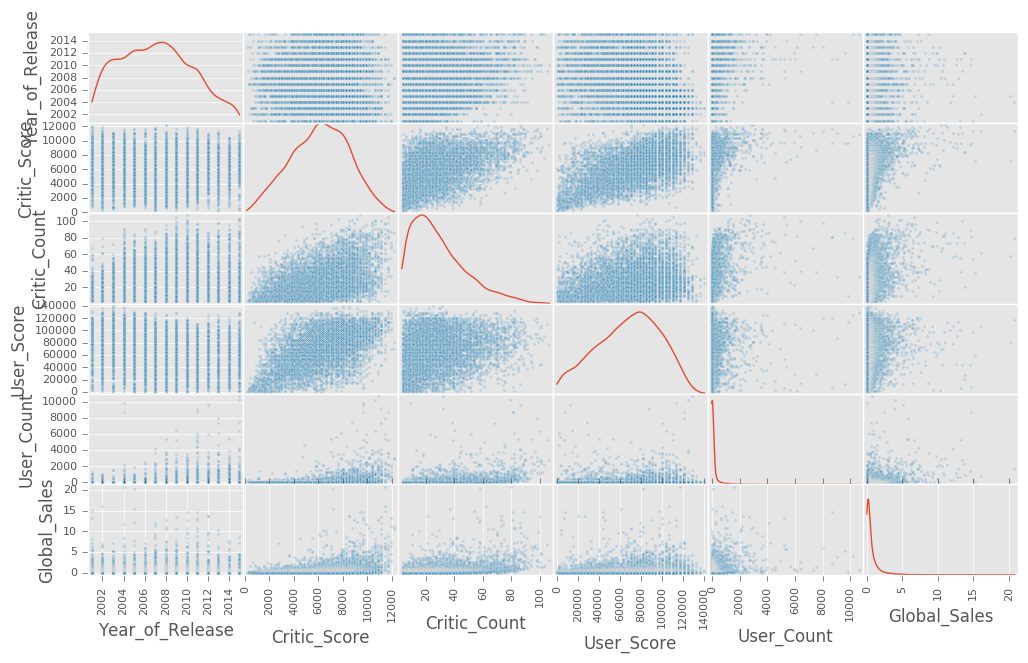

In [453]:
# show distributions
matrix_dataset1 = short_dataset1[['Year_of_Release', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Global_Sales']]
scatter_matrix(matrix_dataset1, alpha=0.2, figsize=(12, 7), diagonal='kde')

In [454]:
# split data into training set and test set
# separate features from target values
features, sales = separateTargetValues(short_dataset1)
test_features, test_sales = separateTargetValues(test_set1)

# get five best predictors
#showKBest(features, sales['Global'])

# shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, sales['Global'], test_size=0.2, random_state=31415)

# Success
print "Training and testing split was successful."

Training and testing split was successful.


time.struct_time(tm_year=2017, tm_mon=2, tm_mday=26, tm_hour=16, tm_min=41, tm_sec=19, tm_wday=6, tm_yday=57, tm_isdst=0)

Regressor: Ridge(alpha=0.08, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.320
R² gap: 0.017


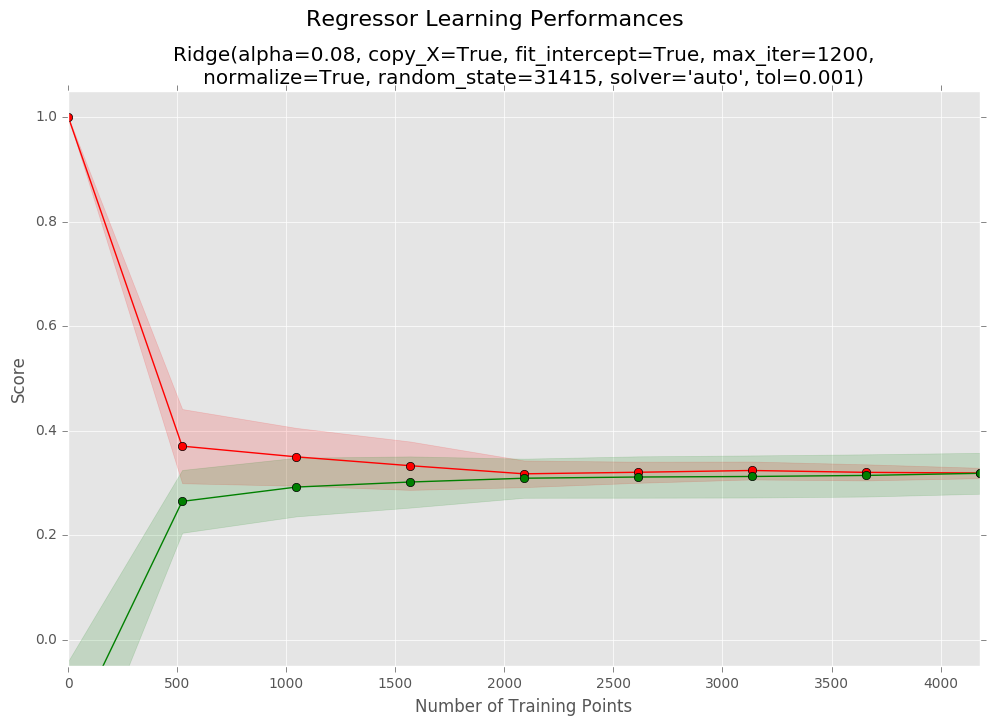

In [455]:
regressors = [0, 1, 2, 3, 4, 5]
reg_params = [0, 1, 2, 3, 4, 5]

random_state = 31415
n_splits = 20
test_size = 0.2

# create a RidgeRegression regressor object (best: 0.3096)
regressor = Ridge(random_state = random_state)
params = {'alpha': [0.08, 0.09, 0.1],    # positve float
          'fit_intercept': [True, False], # boolean
          'max_iter': [1200],             # integer
          'normalize': [True, False],     # boolean
          'solver': ['auto'] # {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag'}
         }
regressors[0] = regressor
reg_params[0] = params

# create a support vector regressor object
regressor = svm.SVR()
params = {'C': [0.7],
          'kernel': ['rbf'],
          'epsilon': [0.27, 0.3, 0.33],
          'gamma': ['auto']
         }       
regressors[1] = regressor
reg_params[1] = params

# create a decision tree regressor object
regressor = DecisionTreeRegressor(random_state = random_state)
params = {'max_depth':(1,2,3,4,5,6,7,8,9,10)}
regressors[2] = regressor
reg_params[2] = params

# create a LarsLasso regressor object
regressor = LassoLars()
params = {'alpha': [0.03, 0.07, 0.1, 0.13],
          'fit_intercept': [True, False],
          'positive': [True, False],
          'normalize': [True, False],
          'max_iter': [1200, 1500]
         }
regressors[3] = regressor
reg_params[3] = params

# create a ElasticNet regressor object
regressor = ElasticNet()
params = {'alpha': [0.07, 0.1],
          'l1_ratio': [0, 0.1, 0.2, 0.3],
          'fit_intercept': [True, False],
          'normalize': [True, False],
          'max_iter' : [1200]
         }
regressors[4] = regressor
reg_params[4] = params

# create a Neural Network regressor object
regressor = MLPRegressor(random_state = random_state)
params = {'hidden_layer_sizes': [(150,), (200,), (250,)],
          'alpha': [0.00093, 0.00097, 0.0001, 0.00013],
          'solver': ['lbfgs', 'sgd', 'adam']
         }
regressors[5] = regressor
reg_params[5] = params

total_start_time = time.time()
display(time.localtime(total_start_time))

results_columns = ['Regressor', 'R2_Train', 'R2_Test', 'R2_Gap', 'Calc_Time', 'Standardized', 'Scaled_0_1', 'Boxcoxed', 'Outlier_Threshold', 'Outlier_Multiety', 'Test_Size', 'N_Splits', 'RND']
results = pd.DataFrame(columns = results_columns)

for index in range(1):
#for index in range(len(regressors)):
    start_time = time.time()
    # Fit the training data to the model using grid search
    reg, reg_score_train, reg_score_test, reg_gap = getScores(X_train, y_train, X_test, y_test, regressors[index], reg_params[index], n_splits, test_size, random_state)
    end_time = time.time()
    
    print 'Regressor: {}'.format(reg)
    print 'R² score (train): {:.3f}'.format(reg_score_train)
    print 'R² gap: {:.3f}'.format(reg_gap)
    
    displayLearningCurve(X_train, y_train, reg, n_splits, test_size, random_state, params)

In [46]:
#STANDARDIZE_SET   = False
#SCALE_SET_0_1     = False
#BOXCOX_SET        = False
#OUTLIER_THRESHOLD = 1.5
#OUTLIER_MULTIETY  = 2
#N_SPLITS          = 20
#TEST_SIZE         = 0.2
#RANDOM_STATE      = 31415

params_standardize_set = [False, True]
params_scale_set_0_1   = [False, True]
params_boxcox_set      = [False]
params_outlier_threshold = [1.5, 1.7, 2.0]
params_outlier_multiety = [1, 2, 3]
params_n_splits = [20]
params_test_size = [0.2, 0.25]
params_random_state = [31415]

combinations = len(params_standardize_set) * len(params_scale_set_0_1) * len(params_boxcox_set) * len(params_outlier_threshold) * len(params_outlier_multiety) * len(params_n_splits) * len(params_test_size) * len(params_random_state)

results_columns = ['Id', 'Regressor', 'R2_Train', 'R2_Test', 'R2_Gap', 'Calc_Time', 'Standardized', 'Scaled_0_1', 'Boxcoxed', 'Outlier_Threshold', 'Outlier_Multiety', 'Test_Size', 'N_Splits', 'RND']
results = pd.DataFrame(columns = results_columns)

rid = 1
best_r2 = (0, -1)
best_gap = (0, -1)

for standardize_set in params_standardize_set:
    for scale_set_0_1 in params_scale_set_0_1:
        for boxcox_set in params_boxcox_set:
            for outlier_threshold in params_outlier_threshold:
                for outlier_multiety in params_outlier_multiety:
                    for n_splits in params_n_splits:
                        for test_size in params_test_size:
                            for random_state in params_random_state:
                                # boxcox does not work on values <= 0
                                if (boxcox_set == True):
                                    standardize_set = False
                                X_train, y_train, X_test, y_test = prepare_sets(standardize_set, scale_set_0_1, boxcox_set, outlier_threshold, outlier_multiety, n_splits, test_size, random_state)
                               
                                regressors = [0, 1, 2, 3, 4, 5]
                                reg_params = [0, 1, 2, 3, 4, 5]

                                # create a RidgeRegression regressor object
                                regressor = Ridge(random_state = random_state)
                                params = {'alpha': [0.03, 0.07, 0.1, 0.13, 0.17],    # positve float
                                          'fit_intercept': [True, False], # boolean
                                          'max_iter': [1200],             # integer
                                          'normalize': [True, False],     # boolean
                                          'solver': ['auto'] # {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag'}
                                         }
                                regressors[0] = regressor
                                reg_params[0] = params

                                # create a support vector regressor object
                                regressor = svm.SVR()
                                params = {'C': [0.7, 1.0, 1.3],
                                          'kernel': ['rbf'],
                                          'epsilon': [0.1, 0.3, 0.7, 1.0],
                                          'gamma': ['auto']
                                         }       
                                regressors[1] = regressor
                                reg_params[1] = params

                                # create a decision tree regressor object
                                regressor = DecisionTreeRegressor(random_state = random_state)
                                params = {'max_depth':(1,2,3,4,5,6,7,8,9,10)}
                                regressors[2] = regressor
                                reg_params[2] = params

                                # create a LarsLasso regressor object
                                regressor = LassoLars()
                                params = {'alpha': [0.03, 0.07, 0.1, 0.13, 0.17],
                                          'fit_intercept': [True, False],
                                          'positive': [True, False],
                                          'normalize': [True, False],
                                          'max_iter': [1200, 1500]
                                         }
                                regressors[3] = regressor
                                reg_params[3] = params

                                # create a ElasticNet regressor object
                                regressor = ElasticNet()
                                params = {'alpha': [0.03, 0.07, 0.1, 0.13, 0.17],
                                          'l1_ratio': [0, 0.1, 0.2, 0.3],
                                          'fit_intercept': [True, False],
                                          'normalize': [True, False],
                                          'max_iter' : [1200]
                                         }
                                regressors[4] = regressor
                                reg_params[4] = params

                                # create a Neural Network regressor object
                                regressor = MLPRegressor(random_state = random_state)
                                params = {'hidden_layer_sizes': [(150,), (200,), (250,)],
                                          'alpha': [0.00093, 0.00097, 0.0001, 0.00013],
                                          'solver': ['lbfgs', 'sgd', 'adam']
                                         }
                                regressors[5] = regressor
                                reg_params[5] = params

                                total_start_time = time.time()
                                display(time.localtime(total_start_time))
                                
                                regs = range(5)
                                #regs = range(len(regressors))
                                
                                for index in regs:
                                    start_time = time.time()
                                    # Fit the training data to the model using grid search
                                    reg, reg_score_train, reg_score_test, reg_gap = getScores(X_train, y_train, X_test, y_test, regressors[index], reg_params[index], n_splits, test_size, random_state)
                                    end_time = time.time()
                                    
                                    print('ID: {} (of {})'.format(rid, combinations * len(regs)))
                                    print('standardize_set={}, scale_set_0_1={}, boxcox_set={}'.format(standardize_set, scale_set_0_1, boxcox_set))
                                    print('outlier_threshold={}, outlier_multiety={}'.format(outlier_threshold, outlier_multiety))
                                    print('n_splits={}, test_size={}, random_state={}'.format(n_splits, test_size, random_state))
                                    print('X_train.shape={}'.format(X_train.shape))
                                    print('Regressor: {}'.format(reg))
                                    print('R² score (train): {:.3f}'.format(reg_score_train))
                                    print('R² gap: {:.3f}'.format(reg_gap))
                                    print('==============================')

                                    if ((reg_score_train > best_r2[0]) | (best_r2[1] < 0)):
                                        best_r2 = (reg_score_train, rid)
                                    if ((reg_gap < best_gap[0]) | (best_gap[1] < 0)):
                                        best_gap = (reg_gap, rid)
                                        
                                    print('best r2: {} / best gap: {}'.format(best_r2, best_gap))
                                    print('==============================')
                                    
                                    #displayLearningCurve(X_train, y_train, reg, n_splits, test_size, random_state, params)

                                    result = pd.DataFrame(
                                        [[
                                                rid,
                                                reg,
                                                reg_score_train,
                                                reg_score_test,
                                                reg_gap,
                                                end_time - start_time,
                                                standardize_set,
                                                scale_set_0_1,
                                                boxcox_set,
                                                outlier_threshold,
                                                outlier_multiety,
                                                test_size,
                                                n_splits,
                                                random_state
                                            ]],
                                        columns = results_columns)
                                    results = results.append(result)
                                    rid = rid + 1
 
display(results)
print('BEST R²')
display(results.nlargest(1, 'R2_Train').head())
print('BEST GAP')
display(results.nsmallest(1, 'R2_Gap').head())

results.to_csv('results_large_grid.csv')

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=9, tm_min=31, tm_sec=48, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 1 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4981, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.278
R² gap: 0.211
best r2: (0.27764275451594633, 1) / best gap: (0.21127295791800849, 1)
ID: 2 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4981, 45)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.752
R² gap: 0.505
best r2: (0.75172397809876434, 2) / best gap: (0.21127295791800849, 1)
ID: 3 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outl

C:\Users\tackeo\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
C:\Users\tackeo\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ID: 5 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4981, 45)
Regressor: ElasticNet(alpha=0.03, copy_X=True, fit_intercept=True, l1_ratio=0,
      max_iter=1200, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
R² score (train): 0.265
R² gap: 0.263
best r2: (0.75172397809876434, 2) / best gap: (0.10711268433129328, 3)


time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=9, tm_min=39, tm_sec=25, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 6 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(4981, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.278
R² gap: 0.211
best r2: (0.75172397809876434, 2) / best gap: (0.10711268433129328, 3)
ID: 7 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(4981, 45)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.752
R² gap: 0.505
best r2: (0.75172397809876434, 2) / best gap: (0.10711268433129328, 3)
ID: 8 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, ou

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=9, tm_min=46, tm_sec=25, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 11 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6083, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.184
R² gap: 0.355
best r2: (0.75172397809876434, 2) / best gap: (0.10711268433129328, 3)
ID: 12 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6083, 45)
Regressor: SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.447
R² gap: 0.003
best r2: (0.75172397809876434, 2) / best gap: (0.0032759821358835373, 12)
ID: 13 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=9, tm_min=59, tm_sec=40, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 16 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6083, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.184
R² gap: 0.355
best r2: (0.75172397809876434, 2) / best gap: (0.0032759821358835373, 12)
ID: 17 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6083, 45)
Regressor: SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.447
R² gap: 0.003
best r2: (0.75172397809876434, 2) / best gap: (0.0032759821358835373, 12)
ID: 18 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_thresho

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=10, tm_min=11, tm_sec=45, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 21 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6404, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.236
R² gap: 0.014
best r2: (0.75172397809876434, 2) / best gap: (0.0032759821358835373, 12)
ID: 22 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6404, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.460
R² gap: 0.391
best r2: (0.75172397809876434, 2) / best gap: (0.0032759821358835373, 12)
ID: 23 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=10, tm_min=27, tm_sec=1, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 26 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6404, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.236
R² gap: 0.014
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 27 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6404, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.460
R² gap: 0.391
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 28 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshol

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=10, tm_min=41, tm_sec=9, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 31 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5105, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.279
R² gap: 0.132
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 32 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5105, 45)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.751
R² gap: 0.377
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 33 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=10, tm_min=49, tm_sec=10, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 36 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(5105, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.279
R² gap: 0.132
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 37 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(5105, 45)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.751
R² gap: 0.377
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 38 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshol

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=10, tm_min=56, tm_sec=35, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 41 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6155, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.189
R² gap: 0.167
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 42 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6155, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.545
R² gap: 0.457
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 43 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=11, tm_min=10, tm_sec=3, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 46 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6155, 45)
Regressor: Ridge(alpha=0.07, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.188
R² gap: 0.141
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 47 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6155, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.545
R² gap: 0.457
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 48 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshol

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=11, tm_min=22, tm_sec=31, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 51 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6446, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.247
R² gap: 0.035
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 52 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6446, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.450
R² gap: 0.449
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 53 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=11, tm_min=38, tm_sec=8, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 56 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6446, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.248
R² gap: 0.044
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 57 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6446, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.450
R² gap: 0.449
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 58 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_thresho

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=11, tm_min=52, tm_sec=39, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 61 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5293, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.287
R² gap: 0.281
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 62 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5293, 45)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.746
R² gap: 0.681
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 63 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=12, tm_min=1, tm_sec=26, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 66 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(5293, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.287
R² gap: 0.281
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 67 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(5293, 45)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.746
R² gap: 0.681
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 68 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshol

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=12, tm_min=9, tm_sec=44, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 71 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6238, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.194
R² gap: 0.107
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 72 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6238, 45)
Regressor: SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.460
R² gap: 0.465
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 73 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=12, tm_min=24, tm_sec=12, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 76 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6238, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.194
R² gap: 0.101
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 77 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6238, 45)
Regressor: SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.460
R² gap: 0.465
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 78 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshol

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=12, tm_min=37, tm_sec=33, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 81 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6488, 45)
Regressor: Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.290
R² gap: 0.042
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 82 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6488, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.443
R² gap: 0.457
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 83 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=12, tm_min=54, tm_sec=5, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 86 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6488, 45)
Regressor: Ridge(alpha=0.07, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.292
R² gap: 0.036
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 87 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6488, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.443
R² gap: 0.457
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 88 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshol

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=13, tm_min=9, tm_sec=29, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 91 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4981, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.278
R² gap: 0.211
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 92 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4981, 45)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -1.635
R² gap: 0.359
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 93 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=13, tm_min=12, tm_sec=1, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 96 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(4981, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.278
R² gap: 0.211
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 97 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(4981, 45)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -1.635
R² gap: 0.359
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 98 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=13, tm_min=14, tm_sec=28, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 101 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6083, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=False, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.184
R² gap: 0.355
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 102 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6083, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -3.113
R² gap: 2.432
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 103 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshol

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=13, tm_min=17, tm_sec=28, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 106 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6083, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=False, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.184
R² gap: 0.355
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 107 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6083, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -3.113
R² gap: 2.432
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 108 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_thresh

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=13, tm_min=20, tm_sec=20, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 111 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6404, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.236
R² gap: 0.014
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 112 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6404, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -0.664
R² gap: 0.594
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 113 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=13, tm_min=23, tm_sec=29, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 116 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6404, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=False, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.236
R² gap: 0.021
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 117 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6404, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -0.664
R² gap: 0.594
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 118 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_thresh

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=13, tm_min=26, tm_sec=26, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 121 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5105, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.279
R² gap: 0.132
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 122 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5105, 45)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -1.840
R² gap: 0.069
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 123 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=13, tm_min=28, tm_sec=50, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 126 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(5105, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.279
R² gap: 0.132
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 127 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(5105, 45)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -1.840
R² gap: 0.069
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 128 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_thresho

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=13, tm_min=31, tm_sec=5, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 131 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6155, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.189
R² gap: 0.167
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 132 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6155, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -2.922
R² gap: 17.383
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 133 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshol

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=13, tm_min=33, tm_sec=44, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 136 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6155, 45)
Regressor: Ridge(alpha=0.07, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.188
R² gap: 0.141
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 137 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6155, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -2.922
R² gap: 17.383
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 138 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_thresh

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=13, tm_min=36, tm_sec=38, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 141 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6446, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.247
R² gap: 0.035
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 142 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6446, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -0.429
R² gap: 0.708
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 143 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=13, tm_min=39, tm_sec=50, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 146 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6446, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=False, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.248
R² gap: 0.042
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 147 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6446, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -0.429
R² gap: 0.708
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 148 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_thresh

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=13, tm_min=42, tm_sec=53, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 151 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5293, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.287
R² gap: 0.281
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 152 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5293, 45)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.7, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -2.172
R² gap: 1.268
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 153 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=13, tm_min=45, tm_sec=40, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 156 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(5293, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.287
R² gap: 0.281
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 157 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(5293, 45)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.7, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -2.172
R² gap: 1.268
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 158 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_thresho

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=13, tm_min=48, tm_sec=14, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 161 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6238, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=False, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.194
R² gap: 0.107
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 162 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6238, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -2.835
R² gap: 4.050
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 163 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshol

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=13, tm_min=51, tm_sec=5, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 166 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6238, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=False, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.194
R² gap: 0.107
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 167 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6238, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -2.835
R² gap: 4.050
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 168 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_thresh

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=13, tm_min=54, tm_sec=5, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 171 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6488, 45)
Regressor: Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.290
R² gap: 0.042
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 172 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6488, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -0.178
R² gap: 0.434
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 173 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=13, tm_min=57, tm_sec=17, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 176 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6488, 45)
Regressor: Ridge(alpha=0.07, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.292
R² gap: 0.036
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 177 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6488, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -0.178
R² gap: 0.434
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 178 (of 360)
standardize_set=False, scale_set_0_1=True, boxcox_set=False
outlier_thresho

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=14, tm_min=0, tm_sec=27, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 181 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4981, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.278
R² gap: 0.206
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 182 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4981, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.407
R² gap: 0.015
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 183 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=14, tm_min=5, tm_sec=2, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 186 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(4981, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.278
R² gap: 0.207
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 187 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(4981, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.407
R² gap: 0.015
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 188 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_thresho

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=14, tm_min=9, tm_sec=7, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 191 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6083, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.184
R² gap: 0.355
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 192 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6083, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.271
R² gap: 0.238
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 193 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=14, tm_min=15, tm_sec=36, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 196 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6083, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.184
R² gap: 0.352
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 197 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6083, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.271
R² gap: 0.238
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 198 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshol

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=14, tm_min=21, tm_sec=41, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 201 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6404, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.237
R² gap: 0.021
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 202 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6404, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.399
R² gap: 0.195
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 203 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=14, tm_min=29, tm_sec=44, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 206 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6404, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.236
R² gap: 0.014
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 207 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6404, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.399
R² gap: 0.195
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 208 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshol

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=14, tm_min=37, tm_sec=9, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 211 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5105, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.279
R² gap: 0.123
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 212 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5105, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.404
R² gap: 0.120
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 213 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=14, tm_min=41, tm_sec=55, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 216 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(5105, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.279
R² gap: 0.123
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 217 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(5105, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.404
R² gap: 0.120
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 218 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_thresho

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=14, tm_min=46, tm_sec=23, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 221 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6155, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.189
R² gap: 0.189
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 222 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6155, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.279
R² gap: 0.200
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 223 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=14, tm_min=53, tm_sec=33, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 226 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6155, 45)
Regressor: Ridge(alpha=0.07, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.188
R² gap: 0.141
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 227 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6155, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.279
R² gap: 0.200
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 228 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshol

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=15, tm_min=0, tm_sec=22, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 231 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6446, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.247
R² gap: 0.035
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 232 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6446, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.415
R² gap: 0.083
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 233 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=15, tm_min=8, tm_sec=33, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 236 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6446, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.248
R² gap: 0.044
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 237 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6446, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.415
R² gap: 0.083
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 238 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_thresho

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=15, tm_min=16, tm_sec=2, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 241 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5293, 45)
Regressor: Ridge(alpha=0.13, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.287
R² gap: 0.275
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 242 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5293, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.406
R² gap: 0.382
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 243 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=15, tm_min=21, tm_sec=2, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 246 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(5293, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.287
R² gap: 0.275
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 247 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(5293, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.406
R² gap: 0.382
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 248 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_thresho

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=15, tm_min=25, tm_sec=45, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 251 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6238, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.194
R² gap: 0.101
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 252 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6238, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.285
R² gap: 0.047
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 253 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=15, tm_min=32, tm_sec=57, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 256 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6238, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.194
R² gap: 0.107
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 257 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6238, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.285
R² gap: 0.047
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 258 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_thresho

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=15, tm_min=39, tm_sec=43, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 261 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6488, 45)
Regressor: Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.290
R² gap: 0.042
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 262 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6488, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.458
R² gap: 0.043
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 263 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=15, tm_min=47, tm_sec=33, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 266 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6488, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.293
R² gap: 0.020
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 267 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6488, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.458
R² gap: 0.043
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 268 (of 360)
standardize_set=True, scale_set_0_1=False, boxcox_set=False
outlier_thresho

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=15, tm_min=54, tm_sec=49, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 271 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4981, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.278
R² gap: 0.211
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 272 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4981, 45)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -1.635
R² gap: 0.359
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 273 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=15, tm_min=57, tm_sec=14, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 276 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(4981, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.278
R² gap: 0.211
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 277 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(4981, 45)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -1.635
R² gap: 0.359
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 278 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=15, tm_min=59, tm_sec=41, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 281 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6083, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=False, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.184
R² gap: 0.355
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 282 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6083, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -3.118
R² gap: 2.433
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 283 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=16, tm_min=2, tm_sec=38, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 286 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6083, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=False, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.184
R² gap: 0.355
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 287 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6083, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -3.118
R² gap: 2.433
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 288 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=16, tm_min=5, tm_sec=34, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 291 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6404, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.236
R² gap: 0.014
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 292 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6404, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -0.662
R² gap: 0.592
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 293 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=16, tm_min=8, tm_sec=42, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 296 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6404, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=False, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.236
R² gap: 0.021
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 297 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6404, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -0.662
R² gap: 0.592
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 298 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=16, tm_min=11, tm_sec=48, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 301 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5105, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.279
R² gap: 0.132
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 302 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5105, 45)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -1.840
R² gap: 0.069
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 303 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=16, tm_min=14, tm_sec=18, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 306 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(5105, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.279
R² gap: 0.132
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 307 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(5105, 45)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -1.840
R² gap: 0.069
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 308 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=16, tm_min=16, tm_sec=50, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 311 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6155, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.189
R² gap: 0.167
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 312 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6155, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -2.939
R² gap: 17.513
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 313 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=16, tm_min=19, tm_sec=46, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 316 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6155, 45)
Regressor: Ridge(alpha=0.07, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.188
R² gap: 0.141
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 317 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6155, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -2.939
R² gap: 17.513
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 318 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=16, tm_min=22, tm_sec=44, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 321 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6446, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.247
R² gap: 0.035
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 322 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6446, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -0.429
R² gap: 0.708
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 323 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=16, tm_min=25, tm_sec=53, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 326 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6446, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=False, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.248
R² gap: 0.042
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 327 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=1.7, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6446, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -0.429
R² gap: 0.708
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 328 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=16, tm_min=28, tm_sec=54, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 331 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5293, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.287
R² gap: 0.281
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 332 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(5293, 45)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.7, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -2.172
R² gap: 1.268
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 333 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=16, tm_min=31, tm_sec=24, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 336 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(5293, 45)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.287
R² gap: 0.281
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 337 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=1
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(5293, 45)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.7, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -2.172
R² gap: 1.268
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 338 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=16, tm_min=33, tm_sec=56, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 341 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6238, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=False, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.194
R² gap: 0.107
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 342 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6238, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -2.848
R² gap: 4.063
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 343 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=16, tm_min=36, tm_sec=43, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 346 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6238, 45)
Regressor: Ridge(alpha=0.17, copy_X=True, fit_intercept=False, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.194
R² gap: 0.107
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 347 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=2
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6238, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -2.848
R² gap: 4.063
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 348 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=16, tm_min=39, tm_sec=33, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 351 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6488, 45)
Regressor: Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.290
R² gap: 0.042
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 352 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(6488, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -0.178
R² gap: 0.434
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 353 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=22, tm_hour=16, tm_min=42, tm_sec=32, tm_wday=2, tm_yday=53, tm_isdst=0)

ID: 356 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6488, 45)
Regressor: Ridge(alpha=0.07, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.292
R² gap: 0.036
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 357 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=2.0, outlier_multiety=3
n_splits=20, test_size=0.25, random_state=31415
X_train.shape=(6488, 45)
Regressor: SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): -0.178
R² gap: 0.434
best r2: (0.75172397809876434, 2) / best gap: (0.0010473211197037369, 24)
ID: 358 (of 360)
standardize_set=True, scale_set_0_1=True, boxcox_set=False
outlier_threshold=

,Id,Regressor,R2_Train,R2_Test,R2_Gap,Calc_Time,Standardized,Scaled_0_1,Boxcoxed,Outlier_Threshold,Outlier_Multiety,Test_Size,N_Splits,RND
0,1.0,"Ridge(alpha=0.03, copy_X=True, fit_intercept=T...",0.277643,0.488916,0.211273,10.988,False,False,False,1.5,1.0,0.20,20.0,31415.0
0,2.0,"SVR(C=0.7, cache_size=200, coef0=0.0, degree=3...",0.751724,0.246894,0.504830,244.372,False,False,False,1.5,1.0,0.20,20.0,31415.0
0,3.0,"DecisionTreeRegressor(criterion='mse', max_dep...",0.280571,0.387684,0.107113,5.455,False,False,False,1.5,1.0,0.20,20.0,31415.0
0,4.0,"LassoLars(alpha=0.03, copy_X=True, eps=2.22044...",0.135450,0.469384,0.333934,40.880,False,False,False,1.5,1.0,0.20,20.0,31415.0
0,5.0,"ElasticNet(alpha=0.03, copy_X=True, fit_interc...",0.264660,0.527602,0.262942,155.095,False,False,False,1.5,1.0,0.20,20.0,31415.0
0,6.0,"Ridge(alpha=0.03, copy_X=True, fit_intercept=T...",0.277643,0.488916,0.211273,9.492,False,False,False,1.5,1.0,0.25,20.0,31415.0
0,7.0,"SVR(C=0.7, cache_size=200, coef0=0.0, degree=3...",0.751724,0.246894,0.504830,218.741,False,False,False,1.5,1.0,0.25,20.0,31415.0
0,8.0,"DecisionTreeRegressor(criterion='mse', max_dep...",0.327506,0.534751,0.207245,5.266,False,False,False,1.5,1.0,0.25,20.0,31415.0
0,9.0,"LassoLars(alpha=0.03, copy_X=True, eps=2.22044...",0.135450,0.469384,0.333934,39.797,False,False,False,1.5,1.0,0.25,20.0,31415.0
0,10.0,"ElasticNet(alpha=0.03, copy_X=True, fit_interc...",0.264660,0.527602,0.262942,146.648,False,False,False,1.5,1.0,0.25,20.0,31415.0


BEST R²


,Id,Regressor,R2_Train,R2_Test,R2_Gap,Calc_Time,Standardized,Scaled_0_1,Boxcoxed,Outlier_Threshold,Outlier_Multiety,Test_Size,N_Splits,RND
0,2.0,"SVR(C=0.7, cache_size=200, coef0=0.0, degree=3...",0.751724,0.246894,0.504830,244.372,False,False,False,1.5,1.0,0.20,20.0,31415.0
0,7.0,"SVR(C=0.7, cache_size=200, coef0=0.0, degree=3...",0.751724,0.246894,0.504830,218.741,False,False,False,1.5,1.0,0.25,20.0,31415.0
0,32.0,"SVR(C=0.7, cache_size=200, coef0=0.0, degree=3...",0.750649,0.373322,0.377328,264.667,False,False,False,1.7,1.0,0.20,20.0,31415.0
0,37.0,"SVR(C=0.7, cache_size=200, coef0=0.0, degree=3...",0.750649,0.373322,0.377328,239.435,False,False,False,1.7,1.0,0.25,20.0,31415.0
0,62.0,"SVR(C=0.7, cache_size=200, coef0=0.0, degree=3...",0.745595,0.064658,0.680937,304.221,False,False,False,2.0,1.0,0.20,20.0,31415.0


BEST GAP


,Id,Regressor,R2_Train,R2_Test,R2_Gap,Calc_Time,Standardized,Scaled_0_1,Boxcoxed,Outlier_Threshold,Outlier_Multiety,Test_Size,N_Splits,RND
0,24.0,"LassoLars(alpha=0.03, copy_X=True, eps=2.22044...",0.193076,0.192029,0.001047,48.716,False,False,False,1.5,3.0,0.20,20.0,31415.0
0,29.0,"LassoLars(alpha=0.03, copy_X=True, eps=2.22044...",0.193076,0.192029,0.001047,47.957,False,False,False,1.5,3.0,0.25,20.0,31415.0
0,164.0,"LassoLars(alpha=0.03, copy_X=True, eps=2.22044...",0.000000,-0.001798,0.001798,18.968,False,True,False,2.0,2.0,0.20,20.0,31415.0
0,169.0,"LassoLars(alpha=0.03, copy_X=True, eps=2.22044...",0.000000,-0.001798,0.001798,21.929,False,True,False,2.0,2.0,0.25,20.0,31415.0
0,344.0,"LassoLars(alpha=0.03, copy_X=True, eps=2.22044...",0.000000,-0.001798,0.001798,20.030,True,True,False,2.0,2.0,0.20,20.0,31415.0


In [467]:
results = pd.read_csv("results_large_grid.csv")

display(results[(results['R2_Gap'] <= 0.1) & (results['R2_Train'] > 0.3)])

display(results['R2_Train'].groupby(results['Standardized']).mean())
display(results['R2_Train'].groupby(results['Scaled_0_1']).mean())
display(results['R2_Train'].groupby(results['Outlier_Threshold']).mean())
display(results['R2_Train'].groupby(results['Outlier_Multiety']).mean())
display(results['R2_Train'].groupby(results['Test_Size']).mean())
display(results['R2_Train'].groupby(results['N_Splits']).mean())

display(results['R2_Gap'].groupby(results['Standardized']).mean())
display(results['R2_Gap'].groupby(results['Scaled_0_1']).mean())
display(results['R2_Gap'].groupby(results['Outlier_Threshold']).mean())
display(results['R2_Gap'].groupby(results['Outlier_Multiety']).mean())
display(results['R2_Gap'].groupby(results['Test_Size']).mean())
display(results['R2_Gap'].groupby(results['N_Splits']).mean())

,Unnamed: 0,Id,Regressor,R2_Train,R2_Test,R2_Gap,Calc_Time,Standardized,Scaled_0_1,Boxcoxed,Outlier_Threshold,Outlier_Multiety,Test_Size,N_Splits,RND
32,0,33,"DecisionTreeRegressor(criterion='mse', max_dep...",0.331925,0.245100,0.086825,4.165,False,False,False,1.7,1.0,0.20,15.0,31415.0
52,0,53,"DecisionTreeRegressor(criterion='mse', max_dep...",0.364611,0.351068,0.013543,5.701,False,False,False,1.7,3.0,0.20,15.0,31415.0
57,0,58,"DecisionTreeRegressor(criterion='mse', max_dep...",0.364611,0.351068,0.013543,5.290,False,False,False,1.7,3.0,0.25,15.0,31415.0
142,0,143,"DecisionTreeRegressor(criterion='mse', max_dep...",0.364611,0.351068,0.013543,3.041,False,True,False,1.7,3.0,0.20,15.0,31415.0
147,0,148,"DecisionTreeRegressor(criterion='mse', max_dep...",0.364611,0.351068,0.013543,2.994,False,True,False,1.7,3.0,0.25,15.0,31415.0
201,0,202,"SVR(C=1.3, cache_size=200, coef0=0.0, degree=3...",0.398296,0.315630,0.082666,215.371,True,False,False,1.5,3.0,0.20,15.0,31415.0
206,0,207,"SVR(C=1.3, cache_size=200, coef0=0.0, degree=3...",0.398296,0.315630,0.082666,195.782,True,False,False,1.5,3.0,0.25,15.0,31415.0
212,0,213,"DecisionTreeRegressor(criterion='mse', max_dep...",0.331925,0.245100,0.086825,2.285,True,False,False,1.7,1.0,0.20,15.0,31415.0
237,0,238,"DecisionTreeRegressor(criterion='mse', max_dep...",0.364611,0.351068,0.013543,2.937,True,False,False,1.7,3.0,0.25,15.0,31415.0
302,0,303,"DecisionTreeRegressor(criterion='mse', max_dep...",0.331925,0.245100,0.086825,2375.000,True,True,False,1.7,1.0,0.20,15.0,31415.0


Standardized
False    0.042623
True     0.022252
Name: R2_Train, dtype: float64

Scaled_0_1
False    0.277131
True    -0.212256
Name: R2_Train, dtype: float64

Outlier_Threshold
1.5    0.018166
1.7    0.032029
2.0    0.047117
Name: R2_Train, dtype: float64

Outlier_Multiety
1.0    0.039502
2.0   -0.136747
3.0    0.194557
Name: R2_Train, dtype: float64

Test_Size
0.20    0.033433
0.25    0.031442
Name: R2_Train, dtype: float64

N_Splits
10.0    0.031806
15.0    0.034647
20.0    0.030859
Name: R2_Train, dtype: float64

Standardized
False    0.594539
True     0.568843
Name: R2_Gap, dtype: float64

Scaled_0_1
False    0.218579
True     0.944802
Name: R2_Gap, dtype: float64

Outlier_Threshold
1.5    0.311780
1.7    0.686420
2.0    0.746872
Name: R2_Gap, dtype: float64

Outlier_Multiety
1.0    0.247729
2.0    1.345057
3.0    0.152286
Name: R2_Gap, dtype: float64

Test_Size
0.20    0.580860
0.25    0.582522
Name: R2_Gap, dtype: float64

N_Splits
10.0    0.665266
15.0    0.620585
20.0    0.459221
Name: R2_Gap, dtype: float64